In [11]:
# load spark DAGs 
import pandas as pd

df = pd.read_csv('/local0/Kariz/expriments/simulator/multidag/config/multi_dag_workload.csv')
df.columns

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride', 'app_runtime',
       'feature', 'tables', 'prefetched_blocks', 'prefetched_bytes', 'bw_i',
       'sequentials'],
      dtype='object')

In [43]:
sptpath = '/local0/Kariz/expriments/simulator/multidag/spark.tpch.template'

def build_graph_from_string(dag_str):
    meta = dag_str.split('\n')[0]
    g_name, g_index = meta.split('Q')[1].split(',')
    g_elements = dag_str.split('\n')[1:]
    g_queuetime = 0
    print(meta, g_index, g_name)
    if len(sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values) == 0:
        return -1
    g_id = sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values[0]
    print('query', g_name, 'index', g_index, 'id', g_id)
    
    g = gt.Graph(directed=True)
    g.gp['name'] = g.new_graph_property("string", 'Q%s,%s'%(g_name,g_index))
    g.gp['id'] = g.new_graph_property("int", str(g_id))
    g.gp['queue_time'] = g.new_graph_property("int", g_queuetime)
    g.gp['cur_stage'] = g.new_graph_property("int", -1)
    status = g.new_vertex_property("int")
    inputs = g.new_vertex_property("string")
    color = g.new_vertex_property("string")
    ops = g.new_vertex_property("string")
    vids = g.new_vertex_property("string")
    sv_gv = {}
    # build vertices
    for el in g_elements[:-1]:
        if el.startswith('v'):
           # print(el)
            vid, operation, inputs_str = el.split(',')[1:]
            v = g.add_vertex()
            vids[v] = vid
            sv_gv[vid] = v
            inputs[v] = inputs_str #build_input_format(inputs_str)
            ops[v] = operation if operation else 'skipped'
            color[v] = '#fb8072' if len(inputs[v]) > 0 else '#bdbdbd' if ops[v] == 'skipped' else '#80b1d3'
            #if g_name == '11' and g_index=='1':
            #    print(v, vids[v], inputs[v])
        
    # build edges
    for el in g_elements[:-1]:
        if el.startswith('e'):
            #if g_name == '11' and g_index=='1' :
            #    print(el)
            v_src, v_dest = el.split(',')[1:]
            e = g.add_edge(sv_gv[v_src], sv_gv[v_dest])

    g.vp['vids'] = vids
    g.vp['color'] = color
    g.vp['tables'] = inputs
    g.vp['status'] = status
    g.vp['feature'] = ops
    return g

dm = df.groupby('app_id')['name', 'app_dag'].agg('max').reset_index()
pd.set_option("display.max_colwidth",800)

string_to_query=[]
n_uniques = 0
for i in range(1,23):
    for j, dag_str in enumerate(dm[dm['name']=='tpch%d'%(i)].groupby('app_dag').agg('max').reset_index()['app_dag'].values):
        n_uniques += 1
        string_to_query.append({'query': i, 'dag': dag_str, 'index': j, 'id': n_uniques})

sq_df = pd.DataFrame(string_to_query)


graphs_pool = {}
with open(sptpath, 'r') as fd:
    dag_strs = fd.read().split('#')[1:]
    for index, dag_str in enumerate(dag_strs):
        g = build_graph_from_string(dag_str)
        if isinstance(g, int):
            continue
        graphs_pool[g.gp.id] = g
        if index ==43:
            break
            
print('Total number of graphs in the graph pool', len(graphs_pool))

t      TPCH_Q1,0 0 1
query 1 index 0 id 1
t      TPCH_Q2,0 0 2
query 2 index 0 id 2
t      TPCH_Q2,1 1 2
t      TPCH_Q2,2 2 2
t      TPCH_Q2,3 3 2
t      TPCH_Q3,0 0 3
query 3 index 0 id 3
t      TPCH_Q4,0 0 4
query 4 index 0 id 4
t      TPCH_Q5,0 0 5
query 5 index 0 id 5
t      TPCH_Q5,1 1 5
query 5 index 1 id 6
t      TPCH_Q5,2 2 5
t      TPCH_Q6,0 0 6
query 6 index 0 id 7
t	TPCH_Q7,0 0 7
query 7 index 0 id 8
t      TPCH_Q7,1 1 7
t      TPCH_Q7,2 2 7
t      TPCH_Q8,0 0 8
query 8 index 0 id 9
t	TPCH_Q9,0 0 9
query 9 index 0 id 10
t      TPCH_Q9,1 1 9
t	TPCH_Q10,0 0 10
query 10 index 0 id 11
t      TPCH_Q10,1 1 10
query 10 index 1 id 12
t      TPCH_Q10,2 2 10
t	TPCH_Q12,0 0 12
query 12 index 0 id 16
t	TPCH_Q13,0 0 13
query 13 index 0 id 17
t      TPCH_Q14,0 0 14
query 14 index 0 id 18
t      TPCH_Q15,0 0 15
query 15 index 0 id 19
t	TPCH_Q16,0 0 16
query 16 index 0 id 20
t      TPCH_Q16,1 1 16
t	TPCH_Q17,0 0 17
query 17 index 0 id 21
t      TPCH_Q17,1 1 17
t      TPCH_Q17,2 2 17
t	TPCH_

In [15]:
queries = df.groupby('app_id')['name'].agg('max').values
print(queries)
queries.reshape(10,10)

['tpch13' 'tpch11' 'tpch4' 'tpch20' 'tpch17' 'tpch15' 'tpch10' 'tpch9'
 'tpch16' 'tpch4' 'tpch20' 'tpch19' 'tpch1' 'tpch3' 'tpch10' 'tpch22'
 'tpch11' 'tpch6' 'tpch2' 'tpch22' 'tpch22' 'tpch11' 'tpch7' 'tpch21'
 'tpch5' 'tpch17' 'tpch14' 'tpch12' 'tpch4' 'tpch9' 'tpch10' 'tpch18'
 'tpch3' 'tpch11' 'tpch21' 'tpch1' 'tpch17' 'tpch4' 'tpch6' 'tpch10'
 'tpch18' 'tpch3' 'tpch16' 'tpch20' 'tpch15' 'tpch2' 'tpch21' 'tpch5'
 'tpch12' 'tpch4' 'tpch9' 'tpch22' 'tpch8' 'tpch6' 'tpch20' 'tpch1'
 'tpch5' 'tpch10' 'tpch11' 'tpch4' 'tpch18' 'tpch22' 'tpch8' 'tpch14'
 'tpch11' 'tpch12' 'tpch9' 'tpch18' 'tpch7' 'tpch8' 'tpch14' 'tpch15'
 'tpch16' 'tpch5' 'tpch4' 'tpch8' 'tpch13' 'tpch6' 'tpch14' 'tpch22'
 'tpch2' 'tpch12' 'tpch3' 'tpch18' 'tpch8' 'tpch1' 'tpch13' 'tpch10'
 'tpch18' 'tpch5' 'tpch8' 'tpch11' 'tpch15' 'tpch1' 'tpch17' 'tpch19'
 'tpch16' 'tpch2' 'tpch18' 'tpch20']


array([['tpch13', 'tpch11', 'tpch4', 'tpch20', 'tpch17', 'tpch15',
        'tpch10', 'tpch9', 'tpch16', 'tpch4'],
       ['tpch20', 'tpch19', 'tpch1', 'tpch3', 'tpch10', 'tpch22',
        'tpch11', 'tpch6', 'tpch2', 'tpch22'],
       ['tpch22', 'tpch11', 'tpch7', 'tpch21', 'tpch5', 'tpch17',
        'tpch14', 'tpch12', 'tpch4', 'tpch9'],
       ['tpch10', 'tpch18', 'tpch3', 'tpch11', 'tpch21', 'tpch1',
        'tpch17', 'tpch4', 'tpch6', 'tpch10'],
       ['tpch18', 'tpch3', 'tpch16', 'tpch20', 'tpch15', 'tpch2',
        'tpch21', 'tpch5', 'tpch12', 'tpch4'],
       ['tpch9', 'tpch22', 'tpch8', 'tpch6', 'tpch20', 'tpch1', 'tpch5',
        'tpch10', 'tpch11', 'tpch4'],
       ['tpch18', 'tpch22', 'tpch8', 'tpch14', 'tpch11', 'tpch12',
        'tpch9', 'tpch18', 'tpch7', 'tpch8'],
       ['tpch14', 'tpch15', 'tpch16', 'tpch5', 'tpch4', 'tpch8',
        'tpch13', 'tpch6', 'tpch14', 'tpch22'],
       ['tpch2', 'tpch12', 'tpch3', 'tpch18', 'tpch8', 'tpch1', 'tpch13',
        'tpch10', 'tpch

j:0,e:->0
j:0,e:->1
j:0,e:0->2
j:0,e:1->2
j:0,e:2->3
j:0,e:3->4
j:1,e:8->9
j:1,e:->5
j:1,e:->6
j:1,e:9->10
j:1,e:5->7
j:1,e:6->7
j:1,e:7->8

-1 0
-1 1
0 2
1 2
2 3
3 4
8 9
-1 5
-1 6
9 10
5 7
6 7
7 8


/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:637: UserWarning: Unknown parameter: size
  warnings.warn("Unknown parameter: " + k, UserWarning)


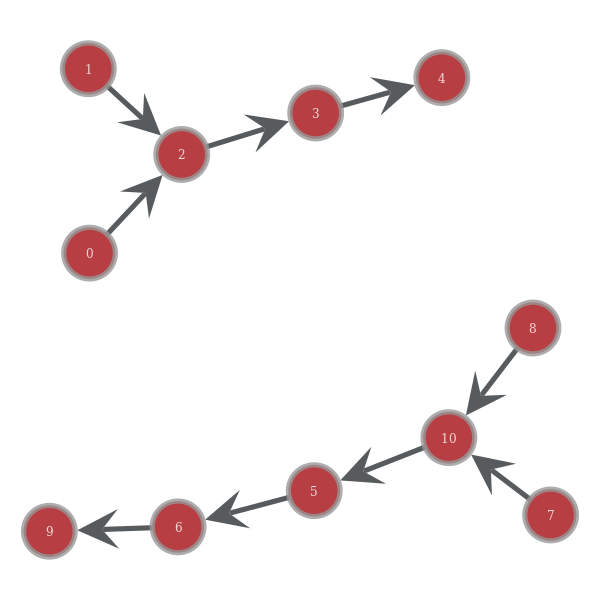

In [41]:
import graph_tool.all as gt

apps = df.groupby('app_id')

convert = lambda a: (int(a[0]) if a[0] != '' else -1, int(a[1]))

for index, app in apps:
    app_str = app['app_dag'].max()
    g = gt.Graph(directed=True)
    sid_v = {}
    print(app_str)
    for ln in app_str.split('\n')[:-1]:
        src, dst = convert(ln.split(':')[-1].split('->'))
        print(src, dst)
        if src != -1 and src not in sid_v:
            v_src = g.add_vertex()
            sid_v[src] = v_src
        if dst not in sid_v:
            v_dst = g.add_vertex()
            sid_v[dst] = v_dst
        if src != -1:
            g.add_edge(sid_v[src], sid_v[dst])
    gt.graph_draw(g, vertex_text=g.vertex_index, size=(700, 700))
   
    break


,dag,id,index,query
0,"j:0,e:->0\nj:0,e:0->1\nj:1,e:->2\nj:1,e:2->3\nj:1,e:3->4\n",1,0,1
1,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:16->17\nj:0,e:->3\nj:0,e:0->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:->12\nj:0,e:5->13\nj:0,e:11->13\nj:0,e:->5\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",2,0,2
2,"j:0,e:->0\nj:0,e:->1\nj:0,e:4->5\nj:0,e:->2\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:2->4\nj:0,e:3->4\n",3,0,3
3,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:1,e:->5\nj:1,e:5->6\nj:1,e:4->6\nj:1,e:6->7\nj:1,e:->4\nj:1,e:7->8\n",4,0,4
4,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:->5\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:12->14\nj:1,e:13->14\nj:1,e:22->23\n",5,0,5
5,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:2->5\nj:0,e:3->5\nj:0,e:->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:12->15\nj:1,e:13->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:15->17\nj:1,e:14->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",6,1,5
6,"j:0,e:->0\nj:0,e:0->1\n",7,0,6
7,"j:0,e:->0\nj:0,e:7->9\nj:0,e:8->9\nj:0,e:->1\nj:0,e:1->5\nj:0,e:4->5\nj:0,e:->2\nj:0,e:->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:5->7\nj:0,e:6->7\nj:0,e:->4\nj:0,e:2->8\nj:0,e:3->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:13->19\nj:1,e:14->19\nj:1,e:15->16\nj:1,e:12->16\nj:1,e:->13\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:->17\nj:1,e:20->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:21->22\nj:1,e:12->14\nj:1,e:11->14\nj:1,e:->11\n",8,0,7
8,"j:0,e:->0\nj:0,e:14->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:->2\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:6->11\nj:0,e:7->11\nj:0,e:10->12\nj:0,e:11->12\nj:0,e:5->13\nj:0,e:4->13\nj:0,e:->5\nj:0,e:->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\nj:1,e:28->30\nj:1,e:29->30\nj:1,e:->16\nj:1,e:30->31\nj:1,e:->17\nj:1,e:31->32\nj:1,e:->24\nj:1,e:->18\nj:1,e:->25\nj:1,e:24->26\nj:1,e:25->26\nj:1,e:22->27\nj:1,e:23->27\nj:1,e:16->19\nj:1,e:17->19\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:->21\nj:1,e:27->28\nj:1,e:26->28\nj:1,e:->22\nj:1,e:20->29\nj:1,e:21->29\nj:1,e:->23\n",9,0,8
9,"j:0,e:->0\nj:0,e:->9\nj:0,e:->1\nj:0,e:0->5\nj:0,e:1->5\nj:0,e:->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:6->8\nj:0,e:7->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:19->20\nj:1,e:18->20\nj:1,e:12->17\nj:1,e:13->17\nj:1,e:23->24\nj:1,e:->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",10,0,9
